In [130]:
# import nltk
# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')

import re
import string
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
# UNCOMMENT TO GET CONVERGENCE LOGS

from gensim.models import LdaModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.similarities import MatrixSimilarity
from gensim.corpora.dictionary import Dictionary
from gensim.test.utils import datapath
from nltk import word_tokenize, WordNetLemmatizer, pos_tag
from nltk.corpus import stopwords, wordnet
from sys import path

from wordcloud import WordCloud, ImageColorGenerator
from pprint import pprint

% matplotlib inline

In [ ]:
# FILE PROCESSING 
def get_subtitle_fns(folder_fn_regex='srt/*'):
    return glob.glob(folder_fn_regex)

def get_subtitle_names(folder_fn_regex='srt/*'):
    filenames = glob.glob(folder_fn_regex)
    return [fn[4:-4] for fn in filenames] # remove srt\\ and .srt

In [17]:
# SUBTITLE PREPROCESSING

# expected subtitle format:
# numeric timestamp index
# timestamp
# subtitles on >= one line
# linebreak

# end of a subtitle line is expected to be a full word (i.e., not hyphenated)

# subtitles may have the following qualities:
# 1. markup (bold, italics, font colour) is between <> 
# e.g., <font color="#00ff00"></font> 
# 2. begin with hyphens
# 3. contain punctuation
# 4. begin (subtitle index 0) and end with subtitle credits of the same format 
# 5. end with "The End"
# 6. contain credits at the start of the subtitles 

def get_subtitle_corpus(subtitle_fns):
    return [preprocess_movie_by_subs(s_fn) for s_fn in subtitle_fns]

def preprocess_movie_by_subs(subtitle_fn):
    return preprocess_subs(get_raw_subs(subtitle_fn))

def get_raw_subs(filename):
    subs = []
    sub_data = []
    
    with open(filename, 'r') as f:
        for line in f:          
            # collect sub lines of some timestamp
            if line != '\n':
                sub_data.append(line[:-1]) # remove newline
                continue
            
            sub_idx = sub_data[0]
            is_sub_author_credits = (sub_idx == '0')
            if is_sub_author_credits: 
                sub_data = []
                continue
            
            # add sub line to all subs
            for i, sub_line in enumerate(sub_data):            
                if i > 1: # index 0 and 1 are sub index and timestamp
                    subs.append(sub_line)
                
            sub_data = []
    
    last_sub_not_included = (sub_data != [])
    if last_sub_not_included:
        for i, sub_line in enumerate(sub_data):            
            if i > 1: # index 0 and 1 are sub index and timestamp
                subs.append(sub_line)
    
    return subs

def preprocess_subs(raw):
    # remove markup
    markup = '<[^>]*>'
    subs = [re.sub(markup, '', r) for r in raw]
    
    # tokenisation case-folding
    subs = [word_tokenize(s.lower()) for s in subs]
    
    # remove stopwords and punctuation
    stops = set(stopwords.words('english'))
    stops = stops.union(string.punctuation)
    subs = [[t for t in sub if t not in stops] for sub in subs]
    
    # lemmatize
    pos = get_pos_tags(subs) # different POS lemmatize differently
    subs = [t for sub in subs for t in sub] # flatten
    lmtzr = WordNetLemmatizer()
    subs = [lmtzr.lemmatize(s, pos[i]) for i, s in enumerate(subs)]
        
    return subs

def get_pos_tags(subs):
    pos = [pos_tag(sub) for sub in subs]
    pos = [get_wordnet_pos(tag) for sub in pos for t, tag in sub] # flatten
    return pos

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else: # default POS in WordNetLemmatizer is noun
        return wordnet.NOUN

def get_vocabulary(bag_of_words):
    return set(bag_of_words)

In [121]:
%%time
# TOPIC MODELLING
def load_lda(filename):
    return LdaModel.load(filename)

movies_corpus = get_subtitle_corpus(get_subtitle_fns()) 
dictionary = Dictionary(movies_corpus)

# remove low information words based on how frequently they appear in 
    # the intra-document and inter-document levels
    # 1. sparsely occurring words for each document; and 
    # 2. words frequent over the WHOLE collection
# remove words appearing in <no_below or >no_above% movies
dictionary.filter_extremes(no_below=2, no_above=0.5) # TODO adjust

movies_corpus = [dictionary.doc2bow(movie) for movie in movies_corpus] # vect

num_topics = 5 # paper used 55
chunksize = 2000 # default
passes = 20 # TODO adjust this ------ GRID SEARCH?
iterations = 400 # TODO adjust this --- passes and iterations must be adjusted to allow convergence
eval_every = None # apparently evaluating model perplexity takes too much time?

lda = LdaModel(movies_corpus, 
               id2word=dictionary,
               chunksize=chunksize,
               passes=passes,
               iterations=iterations,
               num_topics=num_topics,
               eval_every=eval_every)

lda.save(datapath(sys.path[1] + '\\lda')) # absolute path

top_topics = lda.top_topics(movies_corpus, topn=30)
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics

print('Average topic coherence: %.4f' % avg_topic_coherence)
pprint(top_topics)

Average topic coherence: -0.8325
[([(0.04217662, 'witch'),
   (0.028613614, 'demon'),
   (0.027305434, 'ok'),
   (0.0205445, 'war'),
   (0.019195795, 'shop'),
   (0.017710598, 'woman'),
   (0.015139159, 'kind'),
   (0.013319865, 'men'),
   (0.012437337, "ma'am"),
   (0.012436991, 'ever'),
   (0.011890691, 'mark'),
   (0.011084971, 'report'),
   (0.011044198, 'enemy'),
   (0.0110372715, 'rest'),
   (0.009718884, 'course'),
   (0.009717691, 'free'),
   (0.009687312, 'trap'),
   (0.009664297, 'true'),
   (0.009142633, 'grow'),
   (0.008381248, 'henchman'),
   (0.008381173, 'clean'),
   (0.00837414, 'though'),
   (0.008361106, 'burn'),
   (0.008093379, 'heavy'),
   (0.007381977, 'wood'),
   (0.0072548054, 'attack'),
   (0.007029796, 'trouble'),
   (0.007029761, 'else'),
   (0.007029564, 'tacky'),
   (0.0070294742, 'family')],
  -0.33302933502469106),
 ([(0.002866627, 'witch'),
   (0.0028598793, 'demon'),
   (0.002859357, 'ok'),
   (0.0028592765, 'war'),
   (0.0028565607, 'shop'),
   (0.002

In [131]:
# topic similarity
# cosine similarity between topic components 

def get_movie_similarity(index, subtitle_fn):    
    movie = preprocess_movie_by_subs(subtitle_fn)
    sims = index[lda[dictionary.doc2bow(movie)]]
    return sort_desc_movie_similarities(sims)

def get_movie_similarities(lda, index, movies_corpus):
    return [index[lda[movie]] for movie in movies_corpus]

def sort_desc_movie_similarities(sims):
    movie_names = get_subtitle_names()
    return sorted(zip(movie_names, sims), key=lambda sim: -sim[1])

index = MatrixSimilarity(lda[movies_corpus]) 
# if memory is an issue, use Similarity: https://radimrehurek.com/gensim/similarities/docsim.html
# "For example, a corpus of one million documents would require 2GB of RAM in a 256-dimensional LSI space, when used with this class."
# https://radimrehurek.com/gensim/tut3.html

print(get_movie_similarity(index, "srt/spirited away.srt"))
print()

movie_names = get_subtitle_names()
similarities = get_movie_similarities(lda, index, movies_corpus)

for movie, sims in zip(movie_names, similarities):
    print("*****", movie.upper(), "*****")
    print(sort_desc_movie_similarities(sims))
    print()



[('spirited away', 1.0), ('princess mononoke', 0.7703469), ("Howl's Moving Castle 2004", 0.0), ('ponyo', 0.0)]

[[1.         0.         0.63762504 0.        ]
 [0.         1.         0.         0.        ]
 [0.63762516 0.         1.         0.77034676]
 [0.         0.         0.7703469  1.        ]]
***** HOWL'S MOVING CASTLE 2004 *****
[("Howl's Moving Castle 2004", 1.0), ('princess mononoke', 0.63762504), ('ponyo', 0.0), ('spirited away', 0.0)]

***** PONYO *****
[('ponyo', 1.0), ("Howl's Moving Castle 2004", 0.0), ('princess mononoke', 0.0), ('spirited away', 0.0)]

***** PRINCESS MONONOKE *****
[('princess mononoke', 1.0), ('spirited away', 0.77034676), ("Howl's Moving Castle 2004", 0.63762516), ('ponyo', 0.0)]

***** SPIRITED AWAY *****
[('spirited away', 1.0), ('princess mononoke', 0.7703469), ("Howl's Moving Castle 2004", 0.0), ('ponyo', 0.0)]



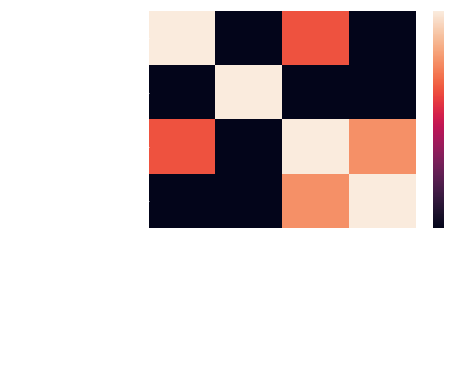

In [137]:
# VISUALISE TOTAL SIMILARITY MATRIX 

def heatmap(matrix):
    movie_names = get_subtitle_names()
    # my window is dark grey, so i need this line to see the tick labels lol
    sns.set_style({'xtick.color': 'white', 'ytick.color': 'white'}) 
    sns.heatmap(matrix, xticklabels=movie_names, yticklabels=movie_names)
    
heatmap(np.array(get_movie_similarities(lda, index, movies_corpus)))

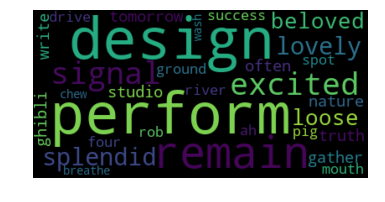

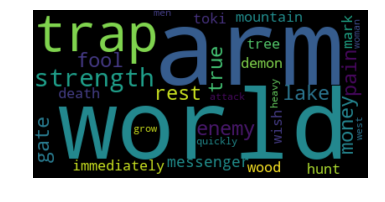

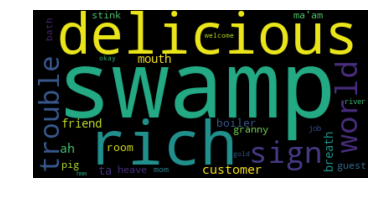

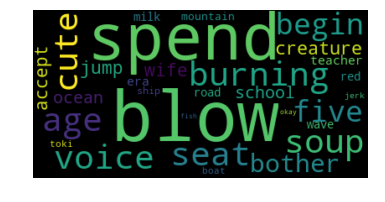

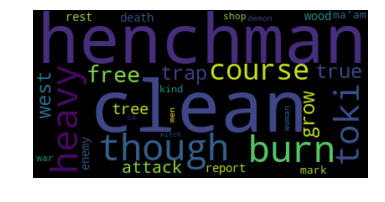

In [104]:
# VISUALISE WORD CLOUD

# based on inverse word likelihood in each topic 
# TODO find word generation approach? :(
def wordcloud(top_topics):
    word_topic_likelihood = 0
    topic_coherence = 1
    likelihoods = [word_topic_likelihood]

    for i in range(len(top_topics)):
        words = []

        for wtl, w in top_topics[i][word_topic_likelihood]:
            frequency = int(round(1/wtl))
            words.append([w] * frequency)

        words = [w for word in words for w in word] # flatten
        words = " ".join(words)

        wordcloud = WordCloud(max_words=30, collocations=False).generate(words)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show() 
        
wordcloud(top_topics)